# Damage Classification in Dual Phase Steels

Modern steels are used in a wide range of applications, from automotive to the construction sector. One of the types of steel with high relevance to industrial applications is the so-called dual-phase steel with a tensile strength of 800 MPa (DP800).
The name originates from the typical microstructure of this material which consists of two phases: hard martensite and softer ferrite.

To improve this kind of steel, it is important to understand its behaviour under stress, in particular, which kind of damage types occur during deformation.  We consider the following types, focussing on the initial stages of damage, that is the nucleation of deformation-induced voids:

- Inclusions: These form during the production process, where, essentially, a foreign particle (e.g. some impurity in the production material) is embedded in the steel. During the preparation of the sample for the SEM imaging, this particle is often lost and a large hole remains.
- Martensite Cracking
- Interface Decohesion.
- Notch Effect: This category was introduced to account for the resolution limit of the micrographs and the strong stress concentration and deformation at point where thin martensite segments meet. In these cases, one cannot unambiguously identify either martensite cracking or interface decohesion as the underlying damage nucleation mechanism.

For further details on these refer to e.g. [Large-area, high-resolution characterisation and classification of damage mechanisms in dual-phase steel using deep learning](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0216493)

All types of damages have in common that they appear as a "dark" region on the sample: As the surface of the sample is disturbed (e.g. cracked in case of a Martensite crack), the electron beam cannot illuminate the inside of these cracks, and, therefore, the damage site appears as a dark region.

Additionally, we need to consider imaging artefacts, in particular shadows: The sample is prepared by grinding and polishing the surface. In order to be able to distinguish the Martensite and ferrite phase, the surface is then slightly etched. Effectively, we have a 3D surface. Since the electron beam cannot reach all parts of the surface in all instances, depending on the local geometry of the sample, the electron beam casts a shadow that can resemble a damage site on the sample.


Because we want analyse the statistical behaviour of the damage sites, we need to look at a large number of different types of damage sites - this we cannot do by hand. Instead, we use machine learning to find and identify damage sites on the sample.
Typically, we record a panoramic image of our sample at high resolution and then use this to analyse the location and type of each individual damage site.

The general workflow after having obtained the image is the following:

- Create positions of damage site candidates by setting a threshold
- Run a clustering algorithm to identify which of these damage site candidates should be considered further
- Run a first neural network to identify inclusions vs other types of damages
- Run a second neural network to identify the remaining types of damages.

The neural networks are trained using a large set of manually labelled images that each have one damage site at their centre, with a given image size around this damage.

## Exercise

Before we start with the technical side, consider the following:

- Why do we follow a two-step approach (locate the damage, then identify the damage), rather than a one-step approach such as, for example, [yolo](https://pjreddie.com/darknet/yolo/) that combines the location and identification steps?
- Why do we need a clustering approach? 
- Which clustering algorithm is most suitable and why?
- Why do we use two networks instead of one?



## Solution 

- Why do we follow a two-step approach? \
One of the aspects of scientific work is to be able to quantify uncertainties. The one-step approach using YOLO or similar approaches requires that we first select and label a set of training data manually. Typically, we use some GUI based tool to draw a rectangle on a large image that contains the object of interest (in our case, a damage site) and label it. However, this is prone to biases, such as, for example:
    - Selection of damage sites: What do human users choose? What do they miss?  
    - How do human users make their selection? Is this repeatable or quantifiable? This may not matter in many applications outside science, but not being able to quantify how each selection step was done prevents us from evaluating uncertainties.
    - Box sizes: If the human users select boxes around potential damage sites manually, the size of the box may vary. This may introduce another bias because different features of the surrounding microstructure are captured.
    - ...
Essentially, in order to avoid these biases, we would have to select the damage sites candidates algorithmically - for example, using a threshold and clustering approach...

  Furthermore, the inclusions are much larger than the other damage types. Therefore, the images may capture a larger area surrounding the inclusions, compared to the other damage types. This may also introduce a bias. Using images of individual damage sites of the same size for all types would increase the likelihood that more than one damage site is captured.

- Why do we need a clustering approach? \ 
The damage sites candidates are found by setting a threshold to identify "dark" regions. However, this is not sufficient. For example, we may have individual small pixels due to random noise that are flagged this way and no damage site is present in the area. Also, we may want to impose a minimum size a damage site has to have before it is considered further. From a practical point of view, we always have the damage site in the centre of the image that is cut out from the panoramic image we start from, having access to the centre of the cluster allows to do this easily

- Which clustering algorithm is suitable? \
We use [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) from the scikit-learn library. This clustering approach can handle noise and, additionally, we do not need to specify the number of clusters beforehand. Instead, we specify parameters that are related to, for example, how far the pixels can be apart to be considered as part of the same cluster, etc.

- Why do we use two networks instead of one ? \
As indicated above, inclusions are much larger than all other damage types, so we would run a high risk of capturing more than one damage site per image if we always used the larger image size.
Additionally, identifying inclusions alone is useful for a range of applications in materials science and, as this is an easier task than classifying all types of damages, it helps to have this as a separate step, depending on what we want to do with the result later on

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# our own helper tools
import clustering
import utils

# if we made any changes to our local utilities, we need to reload them
from importlib import reload
reload(utils)
reload(clustering)

# may result in error messages if used on a computer without GPU
from tensorflow import keras

ModuleNotFoundError: No module named 'clustering'

This is the threshold that we use to identify "dark" regions. We use gray-scale images that have a range between 0 (black) and 255 (white). This value determines what we consider as "dark enough" to be considered as a candidate for a damage site.

### Exercise
Discuss why we cannot simply change the threshold now.
Discuss in which circumstances we would change the threshold.

### Solution:

The threshold is part of the whole workflow starting from identifying the damage site candidates, the clustering, and the later image analysis and classification.
Changing the threshold would change the first element in this chain and, therefore, affect all others. For a given network training, the threshold is a fixed parameter.

We would change this, for example: 
- In the initial setup and determination of the threshold. This value is, essentially, a hyperparameter that needs to be tuned. However, it requires to re-do the complete chain.
- For the evaluation of uncertainties: As we change the threshold, the number of damage site candidates changes, and, therefore, what is found by the clustering step, and so on. Changing the threshold allows us to evaluate how sensitive we are w.r.t. this parameter.

In [3]:
# settings
image_threshold = 20

In [4]:
# dictionary holding all damage sites
# the dictionary uses the coordinanates as keys (i,.e. (x,y)) and the assigned damage type as value.
damage_sites = {}

Here, we load an example image. The panoramic image "X4-Aligned.png" is very large. In order to limit the running time of this notebook, we just take a small part in the upper-left corner. However, you can also experiment with this and use the full image or crop your own selection.

In [5]:
SEM_image = utils.load_image('../data/X4-Aligned_cropped_upperleft.png')


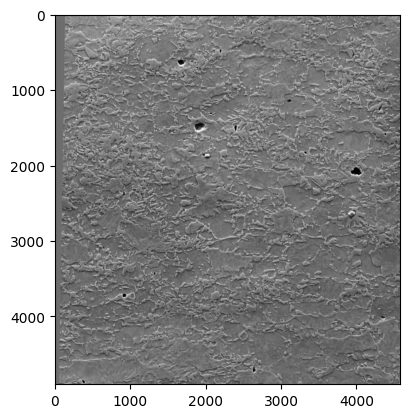

In [6]:
plt.imshow(SEM_image,cmap='gray', vmin=0, vmax=255)
plt.show()

In a first step, we need to find candidates for damage sites.
Therefore, we set a threshold below which we say these pixels belong to a potential damage site.
This is because we see that damages appear as black areas in the SEM image.
Of course, we will also have some artefacts like shadows of the electron beam that we need to consider.

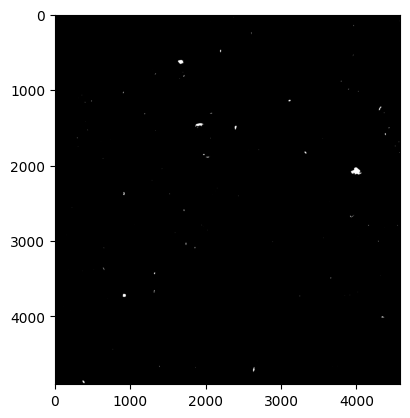

In [7]:
# apply the threshold
tmp_im = SEM_image < image_threshold

# show the image with the damage site candidates
plt.imshow(tmp_im,cmap='gray', vmin=0, vmax=1)
plt.show()

Now, we run the clustering algorithm. The function is in a separate file and returns a list of all (x,y) coordinates of the centres of the clusters we want to consider further.

Two corrections can be applied:
- It can happen that some pixels inside a cluster are above the threshold due to random fluctuations. In order to minimise the impact of this, we can fill these small holes.
- Sometimes, we may find essentially the same cluster multiple times, i.e. different clusters are found by the clustering algorithm that belong to the same damage site. This can, for example, happen for inclusions as they are much larger but, depending on how the pixels are distributed, may result in more than one cluster. We can filter out these events so we do not analyse these damage sites multiple times and distort our statistics.

In [8]:
all_centroids = clustering.get_centroids(SEM_image, image_threshold=image_threshold, 
                                         fill_holes=True, filter_close_centroids=True)
print('Number of damage site candidates: {}'.format(len(all_centroids)))

# clusters 113, #noise 810
Number of damage site candidates: 50


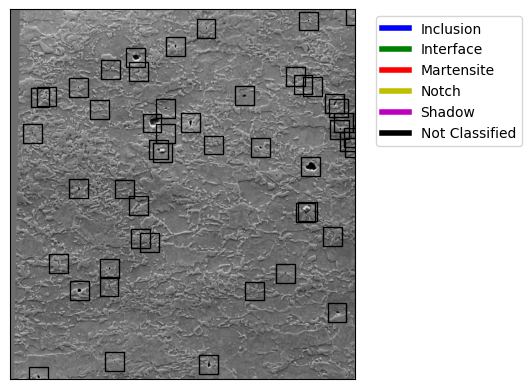

In [9]:
# show an overlay of the damage site candidates found by the clustering algorith.
# as we haven't identified the damage types yet, we add "candidate" as type of damage for each.

for i in range(len(all_centroids)) :
        key = (all_centroids[i][0],all_centroids[i][1])
        damage_sites[key] = 'Not Classified'


utils.show_boxes(SEM_image, damage_sites)

Now we run the first model: Inclusions vs the rest.

The model is pre-trained and we simply load it.

In [10]:
# first model:
# Inception V3: Inclusion vs rest :"Classes":{"Inclusion":0, "Rest":1}, "WindowSize": [250,250],

model1_windowsize = [250,250]
model1_threshold = 0.7

model1 = keras.models.load_model('First_Best_17_60821_test.h5')
model1.compile()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21806882 (83.19 MB)
Trainable params: 21772450 (83.06 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


Before we can run the network, we need to crop out an image of the pre-defined window-size around each cluster centre and put these images into a list that is then passed to the network.

Number of damage candidates to classify: 50


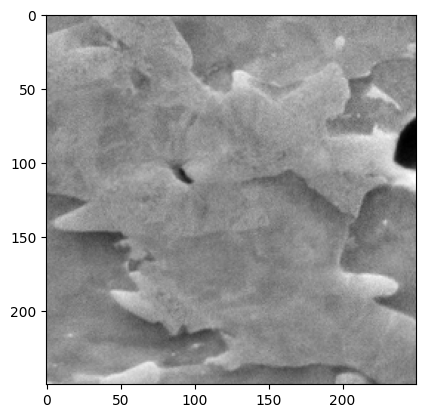

In [11]:
images_model1 = utils.prepare_classifier_input(SEM_image, all_centroids, window_size=model1_windowsize)
print('Number of damage candidates to classify: {}'.format(len(images_model1)))

#show an example image
# here we access the first colour channel as we only have a grey-scale image
plt.imshow(images_model1[0][:,:,0], cmap='grey')
plt.show()

... run the first network

In [12]:
# run the first prediction model: inclusions (class 0) vs the rest (class 1).
y1_pred = model1.predict(np.asarray(images_model1, float))


2/2 [==============================] - 2s 336ms/step


In [13]:
# for each image, we obtain a prediction per class: the first value corresponds to inclusions, the second to the rest:
# (print first 5 elements)
print(y1_pred[0:5])

[[1.9585665e-02 9.8041427e-01]
 [2.1099215e-02 9.7890079e-01]
 [5.0534797e-04 9.9949467e-01]
 [1.3710179e-03 9.9862897e-01]
 [9.7995329e-01 2.0046670e-02]]


Now we filter out all damage sites that are classified as an inclustion. This means that we look at the network output and if it exceeds a defined threshold, this damage site is classified as an inclusion.

In [14]:
# access the first part of the predition tuple, this corresponds to the inclusions.
# we then want to filter out all those that exceed the threshold at which we  assign the label "inclusion" to this damage size
# we then obtain the index for each image, together with the image class (0 is for inclusions)
inclusions = y1_pred[:,0].reshape(len(y1_pred),1)
inclusions = np.where(inclusions > model1_threshold) #np.asarray(inclusions > model1_threshold).nonzero()
print('# inclusions: {}'.format(len(inclusions[0])))

# inclusions: 5


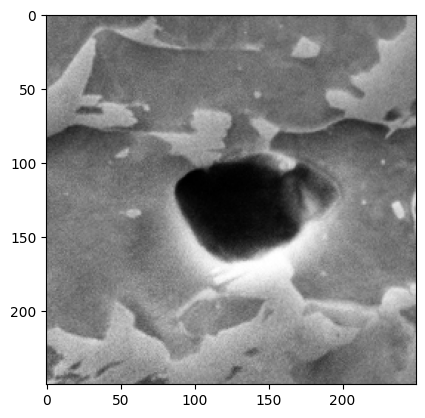

In [15]:
# show an example
# access the first colour channel for the grey-scale information
index = inclusions[0][0]
plt.imshow(images_model1[index][:,:,0], cmap='grey')
plt.show()

Previously, we have added all damage sites to a dictionary with the label "not classified". Now we change the corresponding labels to "inclusion"

ID of the centriod with the damage: 4, coordinates: (633.15,1664.93), key (633.1538173652694, 1664.934505988024)
ID of the centriod with the damage: 11, coordinates: (1146.63,3105.25), key (1146.6293103448277, 3105.252155172414)
ID of the centriod with the damage: 20, coordinates: (1506.32,1883.72), key (1506.32, 1883.72)
ID of the centriod with the damage: 31, coordinates: (2084.22,3987.60), key (2084.2204329461456, 3987.6021647307284)
ID of the centriod with the damage: 46, coordinates: (4014.24,4337.26), key (4014.24251497006, 4337.263473053892)


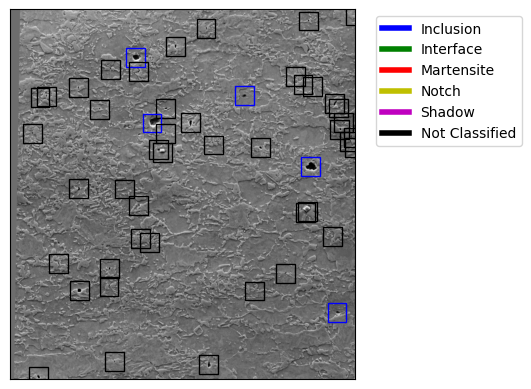

In [16]:
#change the entries in the dictionary
for i in range(len(inclusions[0])):
    centroid_id = inclusions[0][i]
    coordinates = all_centroids[centroid_id]
    key = (coordinates[0], coordinates[1])
    damage_sites[key] = 'Inclusion'
    print('ID of the centriod with the damage: {}, coordinates: ({:.2f},{:.2f}), key {}'.format(centroid_id, coordinates[0], coordinates[1], key))

utils.show_boxes(SEM_image, damage_sites)

Now we prepare for running the second network.
First we remove all damages sites we identified as inclusions from the list of damage site candidates that we need to consider.

In [ ]:
# now for the second network
# remove the identified damage sites from the list of centroids to be considered.

In [17]:
centroids_model2 = []
for key, value in damage_sites.items():
    if value == 'Not Classified':
        coordinates = list([key[0],key[1]])
        centroids_model2.append(coordinates)

print('Remaining damage sites to classify: {}'.format(len(centroids_model2)))

Remaining damage sites to classify: 45


In [18]:
# 2nd network: EERACN, following https://arxiv.org/pdf/1505.00853.pdf

damage_classes = {3: "Martensite",2: "Interface",0:"Notch",1:"Shadowing"}

model2_windowsize = [100,100]
model2_threshold = 0.5

model2 = keras.models.load_model('Best_Second_20_02092021.h5')
model2.compile()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 192)       14592     
                                                                 
 batch_normalization (Batch  (None, 96, 96, 192)       768       
 Normalization)                                                  
                                                                 
 elu (ELU)                   (None, 96, 96, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 160)       30880     
                                                                 
 batch_normalization_1 (Bat  (None, 96, 96, 160)       640       
 chNormalization)                                                
                                                                 
 elu_1 (ELU)                 (None, 96, 96, 160)       0

Then, we need to crop out images from the panoramic image around each remaining cluster centre with the window-size for the second network

Number of damage candidates to classify: 45


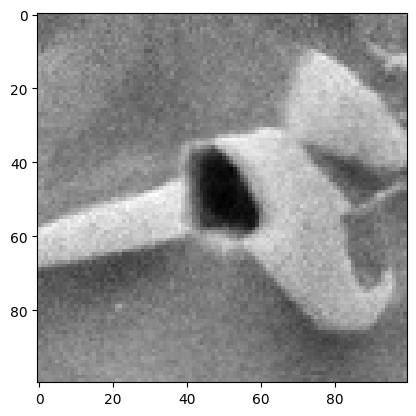

In [19]:
images_model2 = utils.prepare_classifier_input(SEM_image, centroids_model2, window_size=model2_windowsize)
print('Number of damage candidates to classify: {}'.format(len(images_model2)))

#show an example image
# here we access the first colour channel as we only have a grey-scale image
plt.imshow(images_model2[1][:,:,0], cmap='grey')
plt.show()

... and run the model....

In [20]:
# run the first prediction model: for Martensite, Notch, Interface, Shadow
y2_pred = model2.predict(np.asarray(images_model2, float))



2/2 [==============================] - 1s 139ms/step


In [21]:
# this returns a list of preditions for each image to analyse, with values for each of the classes the network has been trained on.
# print first 5 elements as example
print(y2_pred[0:5])

[[3.4378386e-01 2.8619799e-01 6.1860975e-02 3.0815721e-01]
 [2.4472120e-01 2.5351146e-02 2.1082984e-01 5.1909775e-01]
 [1.5090016e-04 2.0051011e-06 2.7709140e-02 9.7213799e-01]
 [7.8041182e-04 1.6533375e-05 4.2541260e-01 5.7379043e-01]
 [2.0382969e-01 6.6067874e-02 4.1686261e-01 3.1323987e-01]]


As before, we now need to update the values in the dictionary holding all damage site candidates. Previously, we replaced "not classified" with "inclsion", now we do the same for the other damage types (and artefacts, such as, for example, shadows).
The prediction (see example above) return the output values per class. Again, we apply a pre-determined threshold and then use the position at which the threshold is exceeded to identify the damage type we want to assign.

In [22]:
# we now apply the treshold at which we assign a damage type to a class
# the following returns a 2D array where the first array determines the index of the centroid that was identified
# the second array is then the damage class identified by the network
damage_index = np.asarray(y2_pred > model2_threshold).nonzero()
print('# identified damages: {} '.format(len(damage_index[0])))

for i in range(len(damage_index[0])):
    index = damage_index[0][i]
    identified_class = damage_index[1][i]
    label = damage_classes[identified_class]
    coordinates = centroids_model2[index]
    #print('Damage {} \t identified as {}, \t coordinates {}'.format(i, label, coordinates))   
    key = (coordinates[0], coordinates[1])
    damage_sites[key] = label

# identified damages: 38 


Finally, we can look at all identified damage sites.
We notice that a few "not classified" cases remain where neither of the networks were able to identify a damage type, i.e., neither of the thresholds was exceeded.

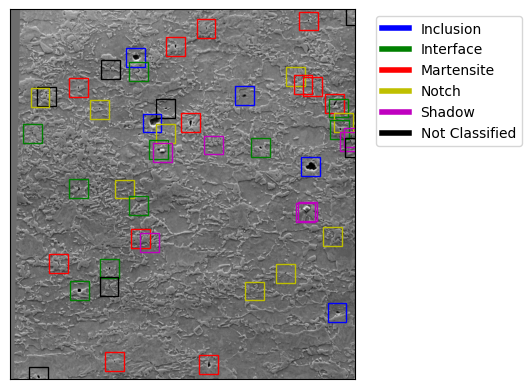

In [23]:
utils.show_boxes(SEM_image, damage_sites)